# Paralelización de la evaluación de los parámetros para un clasificador tipo Random Forest utilizando exclusión mutua

Este ejercicio se trata de evaluar un conjunto de hiperparámetros para un clasiicador tipo Random Forest.

Los hiperparámetros que se se van a variar son:
- El número de árboles (10-210) 
- El criterio para realizar la partición del conjunto de datos (entropy, gini)

In [2]:
# Se importan las bibliotecas necesarias
import time
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Value, Lock, Process, cpu_count
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Imprimir cuántos cores tiene la computadora
cores = cpu_count()
print('Cores en la computadora:', cores)

Cores en la computadora: 4


In [4]:
# Se crea una lista con los hiperparametros a evaluar
hyperparameters = []
# Versión 1
#for criterion in ['gini','entropy']:
#    for trees in range(10, 210):
#        hyperparameters.append([trees, criterion])
# Versión 2
for trees in range(10, 210):
    for criterion in ['gini','entropy']:
        hyperparameters.append([trees, criterion])

In [5]:
# Se carga el conjunto de datos
iris=datasets.load_iris()
X=iris.data
y=iris.target
# Se particiona el conjunto en 80-20 para la evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20)

## Corrida en secuencial

In [ ]:
start_time = time.perf_counter()
evaluate_set(hyperparameters)
finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")

## Corrida en paralelo

In [10]:
def evaluate_hyperparameters(trees, criterion):
    """
    Evaluar los hiperparámetros de un random forest
    Args:
    trees: número de árboles en un random forest
    criterion: criterio para paricionar el conjunto de datos
    """
    clf=RandomForestClassifier(n_estimators=int(trees), criterion=criterion)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(str(trees)+','+criterion+','+accuracy_score(y_test, y_pred))

In [11]:
def evaluate_set(hyperparameter_set):
    """
    Evaluate a set of hyperparameters
    Args:
    hyperparameter_set: a list with the set of hyperparameters to be evaluated
    """
    for s in hyperparameter_set:
        evaluate_hyperparameters(s[0], s[1])  

In [12]:
# Now we will evaluated with more threads
threads=[]
N_THREADS=2
splits=np.split(np.array(hyperparameters), N_THREADS)
for i in range(N_THREADS):
    threads.append(Process(target=evaluate_set, args=[splits[i]]))


start_time = time.perf_counter()
for thread in threads:
    thread.start()
    
for thread in threads:
    thread.join()
            
finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")

Program finished in 48.80912922199968 seconds


## Implementación con exclusión mutua

In [13]:
def evaluate_hyperparameters(contador, lock):
    """
    Evaluar los hiperparámetros de un random forest
    """
    # 7 lineas de código
    while(len(hyperparameters)>contador.value):
        with contador.get_lock():
            elemento=contador.value
            contador.value+=1
        
        clf=RandomForestClassifier(n_estimators=hyperparameters[elemento][0], 
                                   criterion=hyperparameters[elemento][1] )
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        #with lock:
        #    print(str(hyperparameters[elemento][0])+','+hyperparameters[elemento][1]+','+str(accuracy_score(y_test, y_pred)))

In [14]:
# Now we will evaluated with more threads
threads=[]
N_THREADS=2

contador=Value('i',0)
lock = Lock()

for i in range(N_THREADS):
    threads.append(Process(target=evaluate_hyperparameters, args=[contador, lock]))


start_time = time.perf_counter()
for thread in threads:
    thread.start()
    
for thread in threads:
    thread.join()
            
finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")

Program finished in 36.945823410998855 seconds


Program finished in 72.78811879400018 seconds
Program finished in 48.71241386700058 seconds
Program finished in 36.63850077300049 seconds
Program finished in 34.59362515799876 seconds


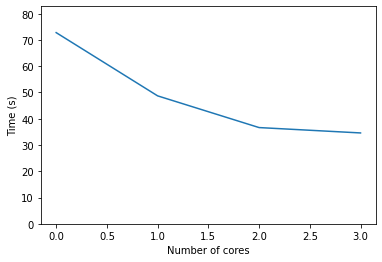

In [15]:
times=[]
for i in range(cores):
    threads=[]
    N_THREADS=i+1

    contador=Value('i',0)
    lock = Lock()

    for i in range(N_THREADS):
        threads.append(Process(target=evaluate_hyperparameters, args=[contador, lock]))


    start_time = time.perf_counter()
    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()

    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    times.append(finish_time-start_time)
plt.ylabel('Time (s)')
plt.xlabel('Number of cores')
plt.ylim(0.0, max(times)+10)
plt.plot(times)